In [2]:
import os
import json
from typing import Dict, List, Optional, Union, cast
from requests import get
from bs4 import BeautifulSoup
import time
import acquire
import acquire_df
from acquire import scrape_github_data
import pandas as pd
import unicodedata
import re
import json
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
import pandas as pd
import acquire


/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Using .json file to import data collected from github
df = pd.read_json("data.json")
df

,repo,language,readme_contents
0,dickreuter/Poker,Python,"Deep mind pokerbot for pokerstars, partypoker ..."
1,pret/pokered,Assembly,# Pokémon Red and Blue [![Build Status][ci-bad...
2,ishikota/PyPokerEngine,Python,# PyPokerEngine\n\n[![Build Status](https://tr...
3,andrewprock/pokerstove,C++,PokerStove\n==========\n\n[![OpenHUB Metrics](...
4,pokerregion/poker,Python,Poker framework for Python\n==================...
...,...,...,...
495,IMGameDesigner/PokerGame,JavaScript,### 满意请给个star\n### [1.0原版js](https://github.co...
496,houen/PokerFace,ActionScript,This [Actionscript Flash poker (5-card & Texas...
497,ngocbd/pokerserver,Java,# pokerserver\n[![Codacy Badge](https://api.co...
498,mikaelbr/AI-Poker-Player,Python,# AI Poker Player\n===========================...


In [4]:
df = df.drop_duplicates(subset='readme_contents', keep='first', inplace=False, ignore_index=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456 entries, 0 to 499
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             456 non-null    object
 1   language         440 non-null    object
 2   readme_contents  456 non-null    object
dtypes: object(3)
memory usage: 14.2+ KB


In [5]:
# Now that I have a dataframe I need to normalize the text using common tools from previous functions to prep the text for parsing

cleaned_df = df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

cleaned_df.info()

# DataFrame.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440 entries, 0 to 499
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             440 non-null    object
 1   language         440 non-null    object
 2   readme_contents  440 non-null    object
dtypes: object(3)
memory usage: 13.8+ KB


In [6]:
cleaned_df.isna().value_counts()


repo   language  readme_contents
False  False     False              440
dtype: int64

In [7]:
cleaned_df.dtypes

repo               object
language           object
readme_contents    object
dtype: object

In [8]:
cleaned_df.readme_contents.astype("str")


0      Deep mind pokerbot for pokerstars, partypoker ...
1      # Pokémon Red and Blue [![Build Status][ci-bad...
2      # PyPokerEngine\n\n[![Build Status](https://tr...
3      PokerStove\n==========\n\n[![OpenHUB Metrics](...
4      Poker framework for Python\n==================...
                             ...                        
495    ### 满意请给个star\n### [1.0原版js](https://github.co...
496    This [Actionscript Flash poker (5-card & Texas...
497    # pokerserver\n[![Codacy Badge](https://api.co...
498    # AI Poker Player\n===========================...
499    # Planning Poker\n[![Codacy Badge](https://api...
Name: readme_contents, Length: 440, dtype: object

In [9]:
cleaned_df = cleaned_df.reset_index()
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   index            440 non-null    int64 
 1   repo             440 non-null    object
 2   language         440 non-null    object
 3   readme_contents  440 non-null    object
dtypes: int64(1), object(3)
memory usage: 13.9+ KB


In [10]:
prepared_df = acquire_df.prepare_poker(cleaned_df.readme_contents)


In [11]:
# now merge the cleaned DF and the original DF, so that we have access to the repo titles and programming language from the original DF 
# as well as the cleaned outputs from the second DF

labeled_df = cleaned_df.merge(prepared_df, how='left', left_on='readme_contents', right_on='content')
#labeled_df = labeled_df.drop(columns='readme_contents')


#DataFrame.merge(right, how='inner', on=None, left_on=None, right_on=None, left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None)

In [12]:
labeled_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 440 entries, 0 to 439
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   index            440 non-null    int64 
 1   repo             440 non-null    object
 2   language         440 non-null    object
 3   readme_contents  440 non-null    object
 4   content          440 non-null    object
 5   stemmed_content  440 non-null    object
 6   lemmed_content   440 non-null    object
dtypes: int64(1), object(6)
memory usage: 27.5+ KB


In [13]:
# labeled_df is the final DF, and I dropped 60 columns due to nulls and duplicate repo issues. This final DF will be used for the explore section
# lets take a look at overall composition by programming language:

def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(labeled_df, "language").tail(10)

,n,percent
Svelte,2,0.004545
Roff,2,0.004545
Vue,2,0.004545
Dart,2,0.004545
F#,1,0.002273
Julia,1,0.002273
Elm,1,0.002273
Apex,1,0.002273
Pascal,1,0.002273
ShaderLab,1,0.002273


In [ ]:
# ADDITIONAL_STOPWORDS = []

# def clean(text):
#         'A simple function to cleanup text data'
#         wnl = nltk.stem.WordNetLemmatizer()
#         stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
#         text = (unicodedata.normalize('NFKD', text)
#                 .encode('ascii', 'ignore')
#                 .decode('utf-8', 'ignore')
#                 .lower())
#         words = re.sub(r'[^\w\s]', '', text).split()
#         return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [14]:
languages = labeled_df.language.unique()
language_df = {}

for lang in languages:
    language_df[lang] = labeled_df[labeled_df.language == lang].lemmed_content
    language_df[lang] = pd.Series(" ".join(language_df[lang].values).split(' '), name=lang).value_counts()

language_df["Python"]

game                    262
poker                   231
player                  230
hand                    200
card                    169
                       ... 
simulatedrawvaluespy      1
outfilecsv                1
playdrawpy                1
nonconvolution            1
midsund                   1
Name: Python, Length: 5104, dtype: int64

## Modeling
### Our text to model is going to be the lemmatized text, labeled_df.lemmed_content

-run a TF-IDF with scikit learn, then run all four categories of classification model

In [21]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")
# get the basics for math and visuals
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# add the tools for classification reports
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# pull in Decision Tree classifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
# pull in Random Forest classifer
from sklearn.ensemble import RandomForestClassifier
# pull in KNN classifer
from sklearn.neighbors import KNeighborsClassifier
# pull in Logistic Regression classifer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
# TF-IDF via scikit learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

### For modeling purposes, I am going to drop any language with less than 3 attributed repos. Less than 3 repos will not adequately segment into train, validate and test dataframes.

In [23]:
# labeled_df is the final DF, and I dropped 60 columns due to nulls and duplicate repo issues. This final DF will be used for the explore section
# lets take a look at overall composition by programming language:

def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(labeled_df, "language").tail(10)

,n,percent
Svelte,2,0.004545
Roff,2,0.004545
Vue,2,0.004545
Dart,2,0.004545
F#,1,0.002273
Julia,1,0.002273
Elm,1,0.002273
Apex,1,0.002273
Pascal,1,0.002273
ShaderLab,1,0.002273


In [24]:
values =['ShaderLab', 'Pascal', 'Apex', 'Elm', 'Julia', 'F#', 'Kotlin', 'Shell', 
'CoffeeScript', 'Lua', 'Svelte', 'Roff', 'Vue', 'Dart']

labeled_df = labeled_df[labeled_df.language.isin(values) == False]

In [25]:
# let's check that it worked
show_counts_and_ratios(labeled_df, "language").tail(10)

,n,percent
Swift,6,0.014354
Elixir,5,0.011962
HTML,5,0.011962
ActionScript,4,0.009569
CSS,4,0.009569
Clojure,4,0.009569
Rust,4,0.009569
Erlang,3,0.007177
Objective-C,3,0.007177
Scala,3,0.007177


In [26]:
#labeled_df.lemmed_content
 # lemmed
 # language
 # tfidf
 # train test split
 #

In [27]:
# split the data
train, validate, test = acquire_df.train_validate_test_split(labeled_df, 'language')

train.shape[0], validate.shape[0], test.shape[0]

(233, 101, 84)

In [28]:
train.columns


Index(['index', 'repo', 'language', 'readme_contents', 'content',
       'stemmed_content', 'lemmed_content'],
      dtype='object')

In [29]:
# create the object
tfidf = TfidfVectorizer()

# fit the vectorizer on all the lemmed_content
X = tfidf.fit_transform(labeled_df.lemmed_content)

y = labeled_df.language
labeled_df = labeled_df.rename(columns={'language': 'programming_language_99'})

In [30]:
# make the df out of the sparse matrix from TDIDF vectorizer
tfidf_df = pd.DataFrame(X.todense(), columns = tfidf.get_feature_names())
# concats with language lables
encoded_df = pd.concat([tfidf_df, labeled_df.programming_language_99.reset_index()], axis=1)

encoded_df.head(1)

,00,000,0000,000000,00005,000050001,0001,000126,000176,0002,...,zoom,zoomed,zoorlcardmodels,zopehttpsgithubcomadzo261,zshenv,zubats,zune,zypper,index,programming_language_99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.077812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Python


In [31]:
encoded_df = encoded_df.reset_index()


In [32]:
values =['ShaderLab', 'Pascal', 'Apex', 'Elm', 'Julia', 'F#', 'Kotlin', 'Shell', 
'CoffeeScript', 'Lua', 'Svelte', 'Roff', 'Vue', 'Dart']

encoded_df = encoded_df[encoded_df.programming_language_99.isin(values) == False]
encoded_df.head()

,level_0,00,000,0000,000000,00005,000050001,0001,000126,000176,...,zoom,zoomed,zoorlcardmodels,zopehttpsgithubcomadzo261,zshenv,zubats,zune,zypper,index,programming_language_99
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.077812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Python
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,Assembly
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,Python
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,C++
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,Python


In [33]:
train, validate, test = acquire_df.train_validate_test_split(encoded_df, 'programming_language_99')
train.head(2)

,level_0,00,000,0000,000000,00005,000050001,0001,000126,000176,...,zoom,zoomed,zoorlcardmodels,zopehttpsgithubcomadzo261,zshenv,zubats,zune,zypper,index,programming_language_99
329,329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,347,JavaScript
208,208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,220,C++


In [34]:
X_train = train.drop(columns=['index', 'programming_language_99'])
y_train = train.programming_language_99

X_validate = validate.drop(columns=['index','programming_language_99'])
y_validate = validate.programming_language_99

X_test = test.drop(columns=['index', 'programming_language_99'])
y_test = test.programming_language_99

## Decision Tree Model


In [35]:
# create an empty list to store the dictionaries
max_depth_list = []
reports = []

# write the for loop to sequentially loop through the values for i,
# setting i as the value, or inverse value, for 
for i in range(1, 11):
        # create the decision tree object with desired hyper-parameters:
        clf = DecisionTreeClassifier(max_depth=i)
    
        # fit the decision tree to the training data:
        clf = clf.fit(X_train, y_train)
    
        #make predictions:
        language_prediction = pd.DataFrame(clf.predict(X_train))
        
        # Predict probability
        language_prediction_proba = pd.DataFrame(clf.predict_proba(X_train))
        
        # compute the estimate accuracy
        train_set_accuracy = clf.score(X_train, y_train)
    
        #evaluate on out-of-sample-date
        validate_set_accuracy = clf.score(X_validate, y_validate)
    
        max_depth_list.append({
                            'max_depth': i,
                            'training_accuracy': train_set_accuracy,
                            'validate_accuracy': validate_set_accuracy
                                    })
df = pd.DataFrame(max_depth_list)
df['difference'] = (df.training_accuracy - df.validate_accuracy)
df.sort_values(['validate_accuracy','difference'], ascending=[False, True]).head(3)

,max_depth,training_accuracy,validate_accuracy,difference
7,8,0.592275,0.405941,0.186334
8,9,0.609442,0.405941,0.203501
9,10,0.622318,0.405941,0.216377


<Figure size 864x648 with 0 Axes>

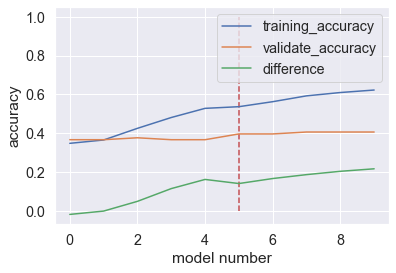

In [37]:
# I selected model #1 because it had the lowest train/val difference of the top 3 performing DTC classifiers
plt.figure(figsize=(12, 9))
sns.set(font_scale = 1.3)
df[['training_accuracy', 'validate_accuracy', 'difference' ]].plot()
plt.ylabel("accuracy")
plt.xlabel("model number")
plt.vlines(x=[5], ymin=0, ymax=1, colors='r', linestyles='dashed')
plt.show()